Author: Milan Malfait

Date: 05/05/2018

# Introduction

This notebook is meant to describe the model used to simulate a tumor population. The underlying mathematics is described and the code is given. The model is based on a Population and a Clone class that contain the necessary attributes and methods to run the simulation. The code in this notebook should correspond to the `MyModel.py` module, used to import the model in other notebooks.

Only test simulations should be carried out in this notebook. All other analyses should be carried out in a separate notebook, with the model imported from its module.

# Modeling Tumor Heterogeneity

## Last changes: 

* Changed `run_simulations()` so it saves the final_data dataframes of the simulated populations immediately by pickling
* Added `tqdm` functionality

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm import tqdm
from ThesisScripts.Analyses import final_data

# Population class


### Stochastic divisions 

To simulate the limited amount of resources within the total population, the number of divisions that each clone undergoes is made stochastic, whereby the division rate is proportionate to the fraction of the total population that belongs to the clone. The probability of having a number of divisions within a certain clone is given by a binomial distribution. 

For the first clone $n_1$, the amount of divisions/proliferators $m_1(t+1)$ for the next generations is an experiment of randomly choosing from the total population size $N$, with a probability equal to $\frac{n_1(t)}{N}$:

$$ m_1(t+1) \sim \operatorname{B}\left\{N(t),\ \frac{n_1(t)}{N(t)}\right\} $$

For the second clone $n_2$, the same Binomial experiment is performed, but now the size of the population from which is chosen, is decreased by the number of proliferators that was achieved for the first clone ($m_1$). The probability is equal to the fraction of $n_2(t)$ in the total population, minus the size of $n_1$. We then get:

$$ m_2(t+1) \sim \operatorname{B}\left\{N(t) - m_1(t+1),\ \frac{n_2(t)}{N(t)-n_1(t)}\right\} $$

This way, the amount of possible divisions decreases for each clone, simulating the limited amount of resources for the total population. For every clone $n_i$ we then get:

$$ m_i(t+1) \sim \operatorname{B}\left\{N(t) - \sum_{j=1}^{i-1}m_j(t+1),\ \frac{n_i(t)}{N(t) - \sum_{j=1}^{i-1}n_j(t)}\right\} $$

#### With selection
Selection can be considered in the model by assigning weights $\mu_i$ to the various clones. These weights are then used in the calculation of the probability for the number of dividers. Clones with a high weight will then have a higher probability to divide, representing a higher fitness advantage. The probability distribution for $m_i(t+1)$ then becomes:

$$ m_i(t+1) \sim \operatorname{B}\left\{N(t) - \sum_{j=1}^{i-1}m_j(t+1),\ \frac{\mu_in_i(t)}{\sum_{j=1}^{K}\mu_jn_j(t) - \sum_{j=1}^{i-1}\mu_jn_j(t)}\right\} $$

where K is the total number of clones.

The weight of the starting clone is set to $1$. For each new subclone $j$, a new weight is randomly generated by sampling $\mu_j$ from a **gamma distribution** with mean the weight of its parent clone $\mu_i$. This distribution generates exclusively positive values and is therefore suitable to sample weights. Furthermore, the form can be modified so that the distribution has a narrow peak and a long tail, something one might expect from the distribution of fitness advantages in case of selection. The gamma distribution is characterized by its shape $k$ and its scale $\theta$, with $\text{mean} = k \cdot \theta$. The scale of the distribution can be set as the **selection factor**, which can be given as a parameter of the Population class initialization. The shape is then calculated as $k = \mu_i / \theta$, with $\mu_i$ the weight of the parent clone. This way the mean of the distribution remains equal to the parent clone's weight. The higher the scale is set, the lower the shape will be and the longer the tail will be of the distribution, making the selection more aggressive. The selection factor can be seen as a measure of the **selective pressure**.

For each subclone $j$ with ancestor $i$, the weight is thus given by:
$$ 
\begin{align}
\mu_j \sim &\operatorname{G}\left\{k,\ \theta \right\} \\
           &\text{with}\ k \cdot \theta = \mu_i
\end{align}
$$
where $k$ and $\theta$ are the shape and scale of the distribution, respectively.


### Stochastic deaths

For each clone, there is a chance that some cells die, with the total number of dying cells in the population surmounting to $D = \alpha N$. At each generation, a random number of cells is chosen according to a conditional hypergeometric distribution from a pool of cells = $D = \alpha N$, with $N$ the total population size and $\alpha$ the fraction of deaths.

$$ d_i(t+1) \sim \operatorname{H}\left\{n_i(t),\ N(t)-\sum_{j=1}^{i}n_j(t),\ D-\sum_{j=1}^{i-1}d_j\right\} $$

This is a hypergeometric distribution with number of "good" items the size of the clone, the number of "bad" items is the remainder of the population clones for which no deaths have been assigned yet, and the number of samples to be drawn is the total number of deaths D minus the number of deaths that have already been fixed for previous clones.



**The new size of the clone at generation $t+1$ is then given by:**

$$ n_i(t+1) = n_i(t) + m_i(t+1) - d_i(t+1) $$



In [2]:
class Population:
    '''
    The Population class will be used to simulate the whole tumor population, which consists of clones and their subclones
    When creating a Population object, a maximal generation (max_gen) and mutation rate (q) should be given
    
    Attributes:
        * gen: the generation or age of the population, starting at 0
        * size_lim: size to which the population grows
        * death_frac: the fraction of the number of divisions that will be counted as deaths
        * start_clone: the initial clone within the population, represented by the Clone class, starting with 1 clone
        * clones: a list to store all clones present in the population, starting with the inital clone
        * mutprob = starting mutation probability; the probability of generating a mutant for the start clone
        * size: total population size, which is the sum of all clones and subclones (calculated with get_size() method)
        * size_vec: vector to store evolution of population sizes (start size = self.size = 1)
        * mut_vec: vector to store number of mutations that occured in each generation (initial value at generation 0 = 0)
        * selection: if > 0: determines the variance in selective advantage for the clones
    '''
    def __init__(self, size_lim, mutprob, mutfactor, death_frac=0, selection=0):
        self.gen = 0
        self.size_lim = size_lim
        self.mutfactor = mutfactor
        self.death_frac = death_frac
        self.size = 1
        self.size_vec = [self.size]
        self.mut_vec = [0]
        self.start_clone = Clone(self, "A", q=mutprob, parent=None, num_mutations=0, weight=1)  # first clone carries 0 mutations and has no advantage
        self.clones = [self.start_clone]
        self.selection=selection
    
    def get_size(self):
        '''Calculates the total population size as the sum of all individual (sub)clone sizes'''
        N = sum((x.size for x in self.clones)) # use generator to sum all clone sizes
        return N
        
    def divisions_deaths(self):
        '''
        Calculates the number of dividing cells for each clone at the current generation, based on a binomial distribution of the total population
        whereby the total number of dividing cells is limited within the population.
        Clone weights are used as a measure of selective advantage when sampling dividers
        For each subclone in the subclones list, the pool from which the binomial distribution chooses is decreased by the sum of dividers of all preceding clones
        the division rate is the fraction of the clone size to the total population size minus the sizes of all preceding clones.
        The number of deaths is calculated stochastically in a similar way but using a Hypergeometric distribution.
        '''
        N = self.get_size()       # total population size
        alpha = self.death_frac   # fraction of deaths
        D = int(round(alpha*N))   # total number of deaths, ROUNDED to get an integer number of deaths

        size_sum = 0  # sum of sizes of all preceding clones, starting at 0
        div_sum = 0   # sum of dividers of all preceding clones, starting at 0
        death_sum = 0
        
        # for selection: only calculate N_weighted when there is selection involved
        if self.selection == 0:
            N_weighted = N
        else:
            N_weighted = sum((x.weight*x.size for x in self.clones))
        
        size_sum_w = 0 # weighted sum of preceding clone sizes, starting at 0
                    
        # do stochastic sampling for all clones except last one (fixed) 
        for clone in self.clones[:-1]:
            n = clone.size
            w = clone.weight
            nw = n*w  # weighted size

            # dividers
            if div_sum >= N:    # total number of dividers cannot exeed total population size!
                clone.dividers = 0
            else:
                clone.dividers = np.random.binomial(N - div_sum, nw/(N_weighted - size_sum_w))
            
            #deaths
            if death_sum >= D:  # total number of deaths cannot exceed D
                clone.deaths = 0
            else:
                clone.deaths = np.random.hypergeometric(n, N - size_sum - n, D - death_sum)
            
            size_sum += n              # update size_sum with current clone size
            size_sum_w += nw
            div_sum += clone.dividers  # update div_sum with current clone dividers
            death_sum += clone.deaths  # update death_sum with current clone deaths
            
        # for last clone: number of dividers and deaths is fixed
        last_clone = self.clones[-1]
        last_clone.dividers = N - div_sum
        last_clone.deaths = D - death_sum
                    
    def simulate(self):
        '''
        Simulates the growth of the tumor population
        After the simulation has completed, all clones that are present are stored in the clones list
        This list will be used to analyze the clone sizes and heterogeneity
        '''
        while self.size < self.size_lim:
            
            self.gen += 1
            
            new_clones = []    # reset new_clones list at each generation
            mutations = 0
                        
            self.divisions_deaths()
            
            # grow and mutate clones
            for clone in self.clones:
                clone.evolve()
                new_clones += clone.new_subs  # add new clones
                mutations += clone.mutators
            
            self.mut_vec.append(mutations)
            
            # update clones list
            self.clones += new_clones
                
            self.size = self.get_size()
            self.size_vec.append(self.size)
                
            
        # convert vector lists to numpy arrays
        self.mut_vec = np.array(self.mut_vec)
        self.size_vec = np.array(self.size_vec)
        
        for clone in self.clones:
            while len(clone.size_vec) < len(self.size_vec):   # adjust length of clone size vector
                clone.size_vec.insert(0,0)
            clone.size_vec = np.array(clone.size_vec)         # convert to numpy array
            
        #print("Simulation completed succesfully\n")

## Clone class


### Stochastic mutations

For each cell division, there is a certain probability that a mutation will occur. To make this process stochastic, the number of mutant cells per generation is picked ranomly from a binomial distribution (based on Wright-Fisher model). For a certain clone $i$ with number of dividers $m_i(t)$ (see divisions_deaths method from Population class) at generation t, the probability of having $k$ mutants is then:

$$ P_i(t)\{\text{k mutants}\} = {m_i(t) \choose k} p^k (1-p)^{m_i(t)-k} $$

where $p$ is the mutation rate (i.e. $q$). From this distribution, a random number is chosen by the numpy.binomial() method.

The number of mutations $k_i(t)$ that occur within a certain clone $i$ with number of dividers $m_i(t)$ at generation $t$ is then randomly generated by the binomial distribution:

$$ k_i(t) \sim \operatorname{B}\left\{m_i(t),\ q\right\} $$

After each round of divisions, the amount of mutations is calculated according to this distribution. The number of new subclones is then equal to $k_i(t)$ and the size of the original clone is reduced by $n_i(t) = n_i(t) - k_i(t)$.

**NEW:** the mutation probability is clone specific. Starting with an arbitrary value for the start clone and increasing with a factor (set by teh population class) for each new subclone. The probability can never exceed 1, however.

In [3]:
class Clone:
    '''
    The Clone class represents a distinct subpopulation of genetic identical cells within the total tumour population.
    Each mutation within a clone leads to a new subclone, which is in turn a clone that grows and can generate subclones of itself.
    
    Attributes:
        * birthday: generation at which the clone was generated
        * size: amount of cells within the clone, start size is always 1
        * dividers: number of cells that will divide (calculated by divisions_deaths method in Population class)
        * deaths: number of cells that will die (calculated by divisions_deaths method in Population class)
        * mutators: number of cells that will mutate
        * subclones: list of subclones that originated from mutations within the current clone, each subclone is in turn a new clone
        * ID: each clone is identified by an ID, this ID is composed of the ancestor ID and a number
        * mutrate: clone specific mutation rate, passed on and increased from its ancestor
        * num_mutations: number of mutations carried by the clone, this number remains constant
        * subid: a number that keeps track of how many subclones have occured within the clone, and is used to assign a unique ID to new subclones
        * size_vec: a vector to store the evolution of the sizes of the clone,
            its length adjusted to the generation the population is currently in (= birthday + 1)
        * weight: the weight that will be used to reflect the selective advantage of the clone when calculating the # dividers in Population.divisions_deaths()
        * parent: the parent clone
        * color: fixed color for the clone to be used in visualizations
    '''
    def __init__(self, population, ID, q, parent, num_mutations, weight):
        self.population = population
        self.parent = parent
        self.birthday = self.population.gen
        self.size = 1
        self.dividers = 0
        self.deaths = 0
        self.mutators = 0
        self.subclones = []
        self.ID = ID
        self.mutrate = q
        self.num_mutations = num_mutations
        self.subid = 0
        self.size_vec = [self.size]
        self.weight = weight
        self.rgb_color = self.set_color()
    
    def evolve(self):
        '''
        Lets the clone grow 
        The divisions  and deaths are STOCHASTIC: the number of dividing and dyingcells (self.dividers) is 
            calculated for each clone by the divisions_deaths() method in the Population class
        The clone size grows with this number of dividing cells and decreases with the number of deaths
        Calculates the number of cells that will mutate (mutators) within the clone, the number of which 
            is chosen randomly according to a binomial distribution from the clone dividers
        Each mutation leads to a new clone and decreases the clone size
        For each new subclone, a new mutation rate q is calculated as an increase to that of its parent
        For each new subclone, a new weight is sampled from a gamme distribution around the weight of the ancestor
        The new size is appended to the size vector
        Returns the list new_subs, containing the new subclones generated at the current generation, which can
            then be used by the Population class to keep track of all new subclones
        '''
        q = self.mutrate                       # clone specific mutation probability
        mutfactor = self.population.mutfactor  # factor with which q will increase for subclones
        new_q = mutfactor*q          # calculate new mutation rate for subclones, based on parent's mutation rate
        if new_q > 1:
            print("Subclones of clone %s have reached 1" %(self.ID))
            new_q = 1
            
        self.new_subs = []   # list of new subclones generated by the current mutation step
        
        self.mutators = np.random.binomial(self.dividers, q)
        
        new_num_mutations = self.num_mutations + 1    # number of mutations for new subclones
        
        # parameters for sampling of new weight from gamma distribution
        if self.population.selection > 0:
            scale = self.population.selection
            shape = self.weight / scale   # so that mean = shape * scale == self.weight (parent clone weight)
        
        
        for i in range(self.mutators):
            
            # calculate new weight for every new subclone, based on parent's weight, from gamma distribution
            if self.population.selection > 0:
                new_weight = np.random.gamma(shape, scale)
            else:
                new_weight = self.weight   # in case of no selection
            
            new_ID = self.ID + "." + str(self.subid + i)  # assign new ID as extension of parent's ID
    
            self.new_subs.append(Clone(self.population, ID=new_ID, q=new_q, parent=self, 
                                       num_mutations=new_num_mutations, weight=new_weight))
        
        self.subclones += self.new_subs  # add new subclones to the total subclones list
        self.subid += self.mutators
        
        self.size = self.size + self.dividers - self.deaths - self.mutators   # update clone size
        self.size_vec.append(self.size)                                       # update clone size vector
        
        return self.new_subs
    
    
    def get_family_size(self):
        '''Returns the total size of the clone and all its descendants.
            Function is recursively called to access all descendants.'''
        
        total = self.size
        
        for sub in self.subclones:
            total += sub.get_family_size()

        return total
    
    
    def get_family_size_vec(self):
        '''Returns a vector that contains the family size of the clone per generation
            This vector is the sum of the clone size vector and the size vectors of all its descendants'''
    
        family_size_vec = np.array(self.size_vec)
        
        for sub in self.subclones:
            family_size_vec = family_size_vec + sub.get_family_size_vec()
            
        return family_size_vec
    
    
    def set_color(self):
        '''Generates a color in RGB format for the clone, based on a lighter tint of its parent color
            For the start_clone (parent == None), the color is set to black (0, 0, 0)'''
        
        if self.parent == None:
            rgb = (0, 0, 0)
        
        elif self.parent == self.population.start_clone:
            # for the mutations in the start clone: generate new random color
            c = lambda: np.random.randint(0, 256)  # generate random value between 0 and 255
            rgb = (c(), c(), c())
            
        else:
            factor = 0.1  # factor with which to change the color tint
            old_rgb = self.parent.rgb_color
            new_rgb = lambda x: tuple(int(factor*(255 - c) + c) for c in x)  # function to generate lighter RGB tint
            rgb = new_rgb(old_rgb)
        return rgb

## Running extensive simulations

In [4]:
def run_simulations(path_prefix, n, size_lim, mutprob, mutfactor, death_frac, selection, pickle='False'):
    '''
    Runs multiple Population simulations with the same parameters.

    Parameters:
    -----------
    * path_prefx : prefix of the filepath to target folder to save data
    * n : int, number of simulations to run
    * size_lim : int, size limit of populations
    * mutprob : float, starting mutation rate for populations
    * mutfactor : float, factor with which to raise the mutation rate for each subclone
    * death_frac : float, death rate for populations
    * selection : float, selection factor for populations

    Returns:
    --------
    * data_list : list, contains the final_data dataframe of each simulated population
    '''

    data_list = []

    for i in tqdm(range(n)):
        pop = Population(size_lim, mutprob, mutfactor, death_frac, selection)
        pop.simulate()
        data = final_data(pop)
        # pickle data
        if pickle == True:
            file_path = path_prefix + 'population_' + str(i)  + '.pkl.gz'
            data.to_pickle(file_path, compression='gzip')
        
        data_list.append(data)
        if len(data_list) % 100 == 0:   # get an update after each 100th population simulated
            print("Populations simulated:", len(data_list))

    return data_list

## Test simulations

### Reference population T (size = $10^6$, q = $10^{-3}$, q_factor = $1$, $\alpha=0.3$, no selection)

In [5]:
%%time

# set seed to get same result for each test simulation
np.random.seed(123)

# Test cell
l = 10**6
q = 10**(-3)
T = Population(l, q, mutfactor= 1, death_frac=0.3)
T.simulate()
print("Total population size:", T.size)
print("Generations:", T.gen)
print()
print("Start clone size:", T.start_clone.size)
print("Total number of mutations:", sum(T.mut_vec))
print("Number of subclones:", len(T.clones[1:]))
print("Total size of subclones:", sum([x.size for x in T.clones[1:]]))
print("Dead clones:", len([x for x in T.clones if x.size == 0]))
print()

Total population size: 1668674
Generations: 27

Start clone size: 1655654
Total number of mutations: 2375
Number of subclones: 2375
Total size of subclones: 13020
Dead clones: 210

CPU times: user 87.6 ms, sys: 2.73 ms, total: 90.3 ms
Wall time: 91.1 ms


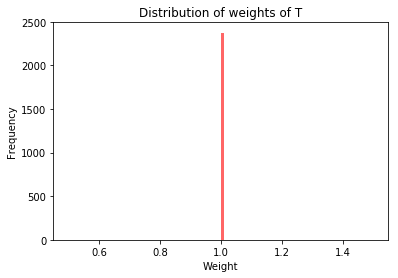

In [6]:
# Check weights of clones for population without selection
weights = []
for clone in T.clones:
    weights.append(clone.weight)

ax = plt.subplot()
plt.hist(weights, bins=100, color='r', alpha=0.6)
plt.title("Distribution of weights of T")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

###  Reference Population with selection T_select (size = $10^6$, q = $10^{-3}$, q_factor = $1$, $\alpha=0.3$,  selection = 0.3)

In [7]:
%%time

# set seed to get same result for each test simulation
np.random.seed(123)

l = 10**6
q = 10**(-3)
T_select = Population(l, q, mutfactor=1, death_frac=0.3, selection=0.3)
T_select.simulate()
print("Total population size:", T_select.size)
print("Generations:", T_select.gen)
print()
print("Start clone size:", T_select.start_clone.size)
print("Total number of mutations:", sum(T_select.mut_vec))
print("Number of subclones:", len(T_select.clones[1:]))
print("Total size of subclones:", sum([x.size for x in T_select.clones[1:]]))
print("Dead clones:", len([x for x in T_select.clones if x.size == 0]))
print()

Total population size: 1668674
Generations: 27

Start clone size: 652519
Total number of mutations: 2449
Number of subclones: 2449
Total size of subclones: 1016155
Dead clones: 274

CPU times: user 150 ms, sys: 11.6 ms, total: 162 ms
Wall time: 163 ms


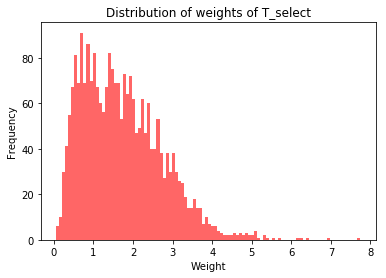

In [8]:
# Check weights of clones for population with selection
weights = []
for clone in T_select.clones:
    weights.append(clone.weight)

plt.figure()
plt.hist(weights, bins=100, color='r', alpha=0.6)
plt.title("Distribution of weights of T_select")
plt.xlabel("Weight")
plt.ylabel("Frequency")
plt.show()

### Test running multiple simulations

In [5]:
%%time
np.random.seed(1)

pfx = ''
l = 10**6
q = 10**(-3)
qfac = 1
alpha = 0.3
sel = 0

pops_data = run_simulations(pfx, 100, l, q, qfac, alpha, sel)

print(len(pops_data))

100%|██████████| 100/100 [00:12<00:00,  7.97it/s]

Populations simulated: 100
100
CPU times: user 11.7 s, sys: 426 ms, total: 12.1 s
Wall time: 12.6 s


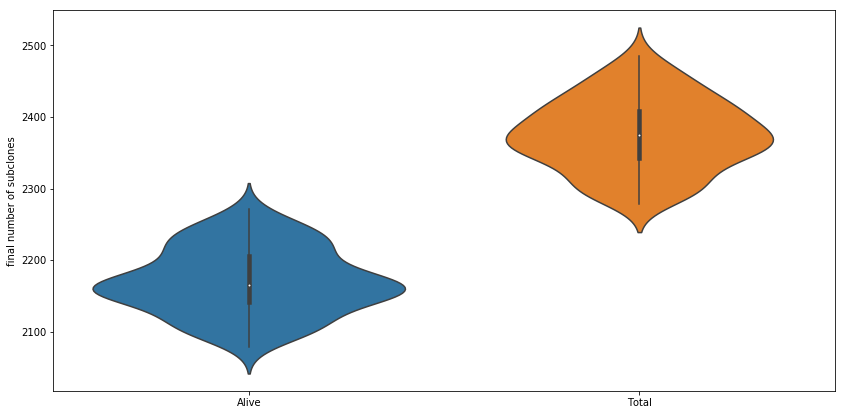

In [6]:
total = np.empty(100)
alive = np.empty(100)

for i in range(len(pops_data)):
    subclones = pops_data[i].iloc[1:]
    living = subclones[subclones["Final size"] > 0]
    total[i] = len(subclones)
    alive[i] = len(living)

data = {'Total': total, 'Alive': alive}
df = pd.DataFrame(data)

plt.figure(figsize=(14,7));
sns.violinplot(data=df);
plt.ylabel('final number of subclones');
plt.show()